# Comparison of data to exponential ("Theory") fit

In this file we compare the existing data to fits provided by exponential function $-k * e^{(-1/tau)*x} + k$. We look for the best parameters in no ranges for k and the ranges [-50, infinity] for tau. We show that the fit provides great results using this formula. However, it is not useful since we only use already existing data and do not take the input into account.

## Preliminaries
### Import libraries

In [1]:
# own libraries
import Global_Functions as gf

# import python folders
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics
import warnings
warnings.filterwarnings(action = 'once')

### Open first experiment for comparison

In [2]:
OPEN_FOLDER = '../Data/Preped_Data/'

In [3]:
image_folder = "../Images/Fit_Comparison/"
gf.check_folder(image_folder)

Folder already exists.


In [4]:
input_data = gf.open_CSV_file('experiment_1.csv', OPEN_FOLDER)
input_data

,time,spinning_soll,el_power,th_power,input_voltage
0,0.00000,0.000000,277.475396,121.785258,0.0
1,0.19982,3996.492326,127.346510,115.213041,0.0
2,1.39874,3996.994912,130.251861,147.214372,10.0
3,2.59766,3996.365506,128.092478,153.764163,10.0
4,3.79658,3996.988395,128.680763,132.849924,10.0
...,...,...,...,...,...
11965,11965.53718,0.000000,879.232827,3703.468626,0.0
11966,11966.53628,0.000000,896.904209,3462.908501,0.0
11967,11967.53538,0.000000,885.894489,3651.875786,0.0
11968,11968.53448,0.000000,887.108372,3421.420301,0.0


## Plot electrical and thermal power for comparison

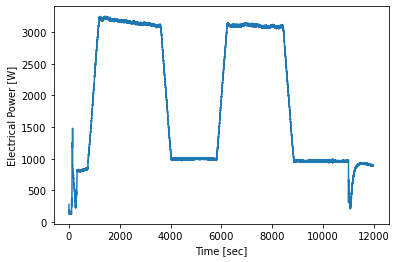

In [5]:
plt.xlabel('Time [sec]')
plt.ylabel('Electrical Power [W]')
plt.plot(input_data['time'], input_data['el_power'])
plt.show()

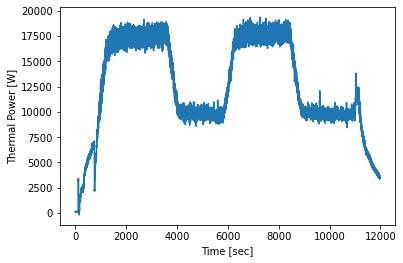

In [6]:
plt.xlabel('Time [sec]')
plt.ylabel('Thermal Power [W]')
plt.plot(input_data['time'], input_data['th_power'])
plt.show()

## Approximate using regression method

Formula to approximate is -k* np.exp((-1/tau)* time) +k \
In the approximations of our expert were for k 5900 and for tau 330 or 680

In [1]:
def approx_func(x, k, tau):
    return gf.exp_func(x, k, tau)

In [8]:
def approximation(time, values, prior):
    assert len(time) == len(values), 'time and values should have the same length'
    segment_start_value = values[prior]
    param_bounds = ([-np.inf, 50], [np.inf, np.inf])
    para_fit, pcov = scipy.optimize.curve_fit(approx_func, time-prior, values-segment_start_value, bounds=param_bounds)
    k_best = para_fit[0]
    tau_best = para_fit[1]
    return k_best, tau_best

In [9]:
def all_approximations(data_time, data_value, time_splits):
    fig,axs = plt.subplots(math.ceil(len(time_splits)/2), 2, figsize = (20,12))
    axs = axs.ravel()
    approximations = np.full(shape = len(data_time), fill_value= np.nan)
    for t in range(len(time_splits) -1):
        cut_point_prior = math.ceil(time_splits[t])
        cut_point_post = math.ceil(time_splits[t+1])
        time_segment = data_time[cut_point_prior:cut_point_post]
        value_segment = data_value[cut_point_prior:cut_point_post]
       
        k_best, tau_best = approximation(data_time[cut_point_prior:cut_point_post],
                                  data_value[cut_point_prior:cut_point_post],
                                  cut_point_prior)
        
        segment_approximation = approx_func(time_segment-cut_point_prior, k_best, tau_best) + data_value[cut_point_prior]
        axs[t].plot(time_segment, value_segment)
        axs[t].plot(time_segment, segment_approximation)
        approximations[cut_point_prior:cut_point_post] = segment_approximation
    
    axs[-1].plot(data_time, data_value)
    axs[-1].plot(data_time, approximations)
    return approximations

In [10]:
def get_time_splits(input_data):
    time_splits = [int(input_data.iloc[x]['time']) for x in range(len(input_data)-1) if input_data.iloc[x]['input_voltage'] != input_data.iloc[x+1]['input_voltage']]
    time_splits.append(len(input_data))
    time_splits.insert(-1, 11025)
    time_splits.insert(1, 850)
    return time_splits

In [11]:
time_splits = get_time_splits(input_data)

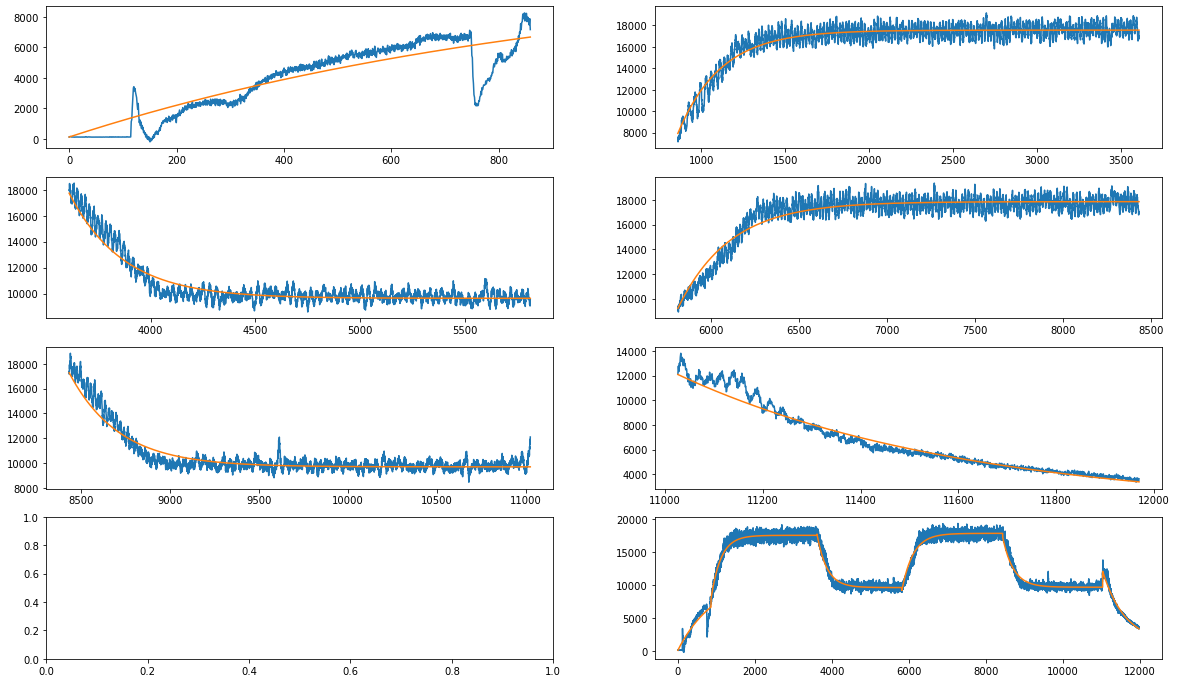

In [12]:
input_data['th_approx'] = all_approximations(input_data['time'], input_data['th_power'], time_splits)

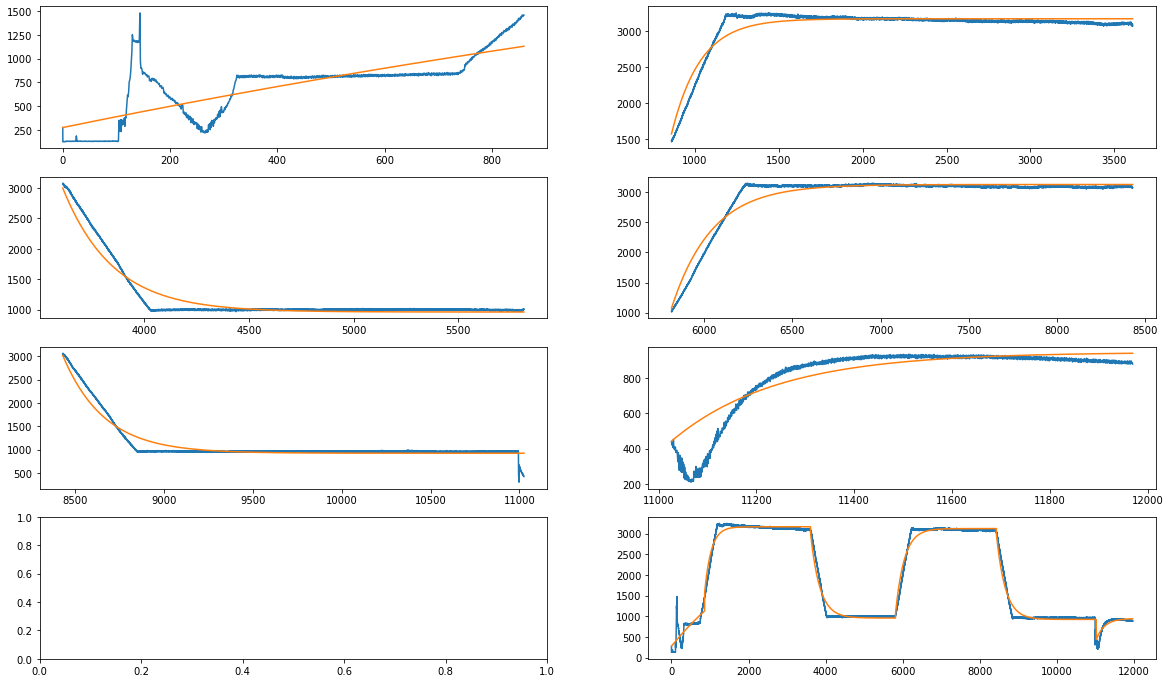

In [13]:
input_data['el_approx'] = all_approximations(input_data['time'], input_data['el_power'], time_splits)

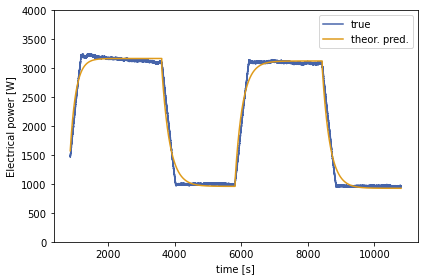

In [14]:
cutpoint = 850
uppercut = 10800

fig, ax1 = plt.subplots()

color = gf.get_color('blue')
ax1.plot(input_data['time'][cutpoint:uppercut], input_data['el_power'][cutpoint:uppercut], label = 'true', color = color)
ax1.set_ylabel('Electrical power [W]')
ax1.set_ylim([0,4000])
ax1.set_xlabel('time [s]')

color = gf.get_color('orange')
ax1.plot(input_data['time'][cutpoint:uppercut], input_data['el_approx'][cutpoint:uppercut], label = 'theor. pred.', color = color)
fig.tight_layout()
plt.legend()
plt.savefig(image_folder + 'ex4_theo_compar_elec.svg')
plt.savefig(image_folder + 'ex4_theo_compar_elec.png')
plt.show()

In [15]:
gf.measure_difference(input_data['el_power'], input_data['el_approx'], should_print=True)

The RMSE is 113.849
The R2-score is 0.988
The MAE is 75.709
The MaxAE is 1040.609


[113.84851430346724, 0.9884709193281083, 75.70896068377485, 1040.6085270357466]